<img src="logo-text.png"/>

### PyData NYC 2015

**Michael Droettboom** | mdroettboom@continuum.io | Continuum Analytics

**Thomas A Caswell** |  tcaswell@{bnl.gov, gmail.com} | Brookhaven National Labratory

Co-lead developers of matplotlib

This notebook requires matplotlib 1.5.0

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime as dt
import itertools
import matplotlib

## matplotlib is alive and well

- Officially a NumFocus project
- More developer resources available

### Other stats

- matplotlib.org
  - 470k sessions/month
  - 1.4m page views/month
  - google thinks 190k users/month
  - cute patterns in time
- github
  - 40k views/month
  - 14k users/month
  - 1.3k unique cloners/month
  - 1.3k forks
- source forge
  - 60-120k monthly downloads (39-55% windows)
  - 2M total downloads in last 2 years
  - spikes of 100k/month around releases
- pypi
  - 190k/month
- Debian popcon
  - 93rd percentile in popularity among all Debian packages
- Other
  - Doesn't include Cristoph Gohlke, Enthought Canopy, Continuum Anaconda, other Linux and Mac packaging

## Release Schedule

- October 29, 2015: Version 1.5.0
- Q4, 2015: Version 2.0: Style changes only
- Q2, 2016: Version 2.1: Regular feature release

# DEMOS

All working with 1.5.0

## Notebook AGG (`%matplotlib nbagg` or `%matplotlib notebook`)

 - interactive front end for mpl in the notebook
 - needs a live python kernel on the server side
   - only a png in nbviewer
 - Mike Droettboom, Jason Grout, Phil Elson, Steven Silvester 
 - full mouse/key events back into python layer

In [2]:
fig, ax = plt.subplots()
x = np.linspace(0,10,10000)
y = np.sin(x)
ln, = ax.plot(x,y, lw=3)
evt = []
colors = iter(itertools.cycle(['r', 'g', 'b', 'k', 'purple']))

txt = ax.annotate('.', (.5, .5), xycoords='axes fraction', ha='center')

def on_event(event):
    if event.name.startswith('key'):
        if len(event.key) == 1:
            txt.set_text(txt.get_text() + event.key)
        elif event.key == 'backspace':
            txt.set_text(txt.get_text()[:-1])
        fig.suptitle('%s: %s' % (event.name, event.key))
    elif event.name == 'scroll_event':
        fig.suptitle('%s: %s' % (event.name, event.step))
    else:
        fig.suptitle('%s: %s' % (event.name, event.button))
    evt.append(event)
    ln.set_color(next(colors))

fig.canvas.mpl_connect('button_press_event', on_event)
fig.canvas.mpl_connect('button_release_event', on_event)
fig.canvas.mpl_connect('scroll_event', on_event)
fig.canvas.mpl_connect('key_press_event', on_event)

<IPython.core.display.Javascript object>

10

## 3D

In [3]:
from mpl_toolkits.mplot3d import Axes3D


def lorenz(x, y, z, s=10, r=28, b=2.667):
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

dt = 0.01
stepCnt = 10000

# Need one more for the initial values
xs = np.empty((stepCnt + 1,))
ys = np.empty((stepCnt + 1,))
zs = np.empty((stepCnt + 1,))

# Setting initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Stepping through "time".
for i in range(stepCnt):
    # Derivatives of the X, Y, Z state
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, alpha=.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

<IPython.core.display.Javascript object>

## Rich user interaction

In [4]:
# Creates two identical panels.  Zooming in on the right panel will show
# a rectangle in the first panel, denoting the zoomed region.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# We just subclass Rectangle so that it can be called with an Axes
# instance, causing the rectangle to update its shape to match the
# bounds of the Axes
class UpdatingRect(Rectangle):
    def __call__(self, ax):
        self.set_bounds(*ax.viewLim.bounds)
        ax.figure.canvas.draw_idle()

# A class that will regenerate a fractal set as we zoom in, so that you
# can actually see the increasing detail.  A box in the left panel will show
# the area to which we are zoomed.
class MandlebrotDisplay(object):
    def __init__(self, h=500, w=500, niter=50, radius=2., power=2):
        self.height = h
        self.width = w
        self.niter = niter
        self.radius = radius
        self.power = power

    def __call__(self, xstart, xend, ystart, yend):
        self.x = np.linspace(xstart, xend, self.width)
        self.y = np.linspace(ystart, yend, self.height).reshape(-1,1)
        c = self.x + 1.0j * self.y
        threshold_time = np.zeros((self.height, self.width))
        z = np.zeros(threshold_time.shape, dtype=np.complex)
        mask = np.ones(threshold_time.shape, dtype=np.bool)
        for i in range(self.niter):
            z[mask] = z[mask]**self.power + c[mask]
            mask = (np.abs(z) < self.radius)
            threshold_time += mask
        return threshold_time

    def ax_update(self, ax):
        ax.set_autoscale_on(False) # Otherwise, infinite loop

        #Get the number of points from the number of pixels in the window
        dims = ax.axesPatch.get_window_extent().bounds
        self.width = int(dims[2] + 0.5)
        self.height = int(dims[2] + 0.5)

        #Get the range for the new area
        xstart,ystart,xdelta,ydelta = ax.viewLim.bounds
        xend = xstart + xdelta
        yend = ystart + ydelta

        # Update the image object with our new data and extent
        im = ax.images[-1]
        im.set_data(self.__call__(xstart, xend, ystart, yend))
        im.set_extent((xstart, xend, ystart, yend))
        ax.figure.canvas.draw_idle()

md = MandlebrotDisplay()
Z = md(-2., 0.5, -1.25, 1.25)

fig1, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Z, origin='lower', extent=(md.x.min(), md.x.max(), md.y.min(), md.y.max()), cmap='YlGnBu')
ax2.imshow(Z, origin='lower', extent=(md.x.min(), md.x.max(), md.y.min(), md.y.max()), cmap='YlGnBu')

rect = UpdatingRect([0, 0], 0, 0, facecolor='None', edgecolor='black', lw=2)
rect.set_bounds(*ax2.viewLim.bounds)
ax1.add_patch(rect)

# Connect for changing the view limits
ax2.callbacks.connect('xlim_changed', rect)
ax2.callbacks.connect('ylim_changed', rect)

ax2.callbacks.connect('xlim_changed', md.ax_update)
ax2.callbacks.connect('ylim_changed', md.ax_update)

ax2.set_title('zoom on me')
ax1.set_title('over')

<IPython.core.display.Javascript object>

## Animation

<IPython.core.display.Javascript object>


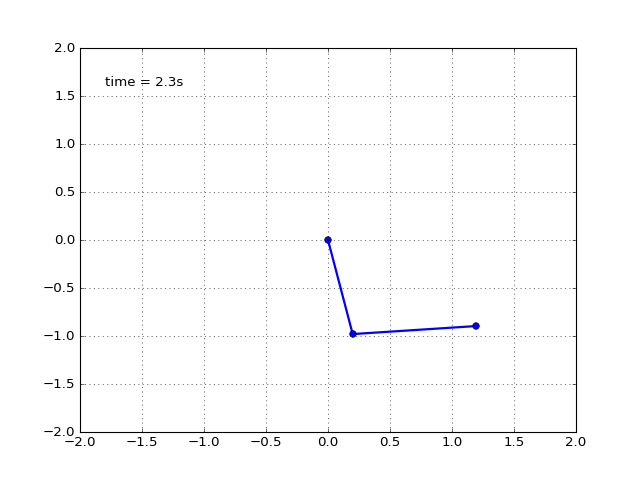

In [6]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg

def derivs(state, t):
    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_)
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0.0, 20, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=25, blit=True, init_func=init)

plt.show()


## matplotlib.style
 - partially update rcparams (default values)
 - Tony Yu 

In [7]:
import matplotlib.style as ms
ms.available

['bmh',
 'seaborn-whitegrid',
 'seaborn-dark',
 'dark_background',
 'seaborn-colorblind',
 'seaborn-talk',
 'grayscale',
 'seaborn-poster',
 'seaborn-notebook',
 'seaborn-pastel',
 'seaborn-paper',
 'ggplot',
 'seaborn-dark-palette',
 'seaborn-muted',
 'fivethirtyeight',
 'seaborn-darkgrid',
 'seaborn-white',
 'seaborn-ticks',
 'seaborn-bright',
 'seaborn-deep',
 'classic']

<IPython.core.display.Javascript object>


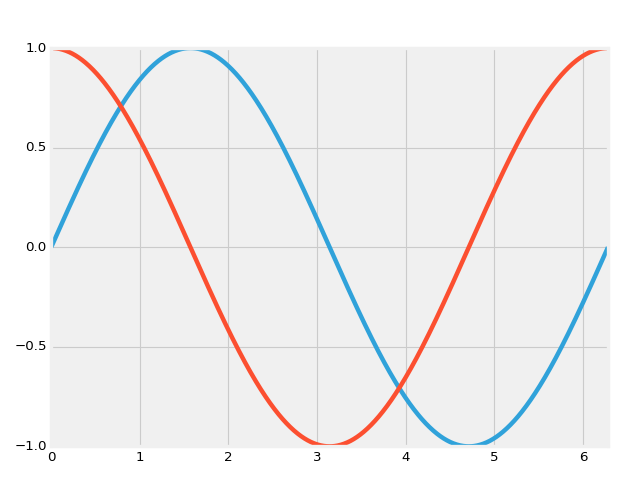

In [8]:
th = np.linspace(0, 2*np.pi, 1024)

with ms.context('fivethirtyeight'):
    fig, ax = plt.subplots()
    ln_sin, = ax.plot(th, np.sin(th))
    ln_cos, = ax.plot(th, np.cos(th))
    ax.set_xlim(0, 2*np.pi)

<IPython.core.display.Javascript object>


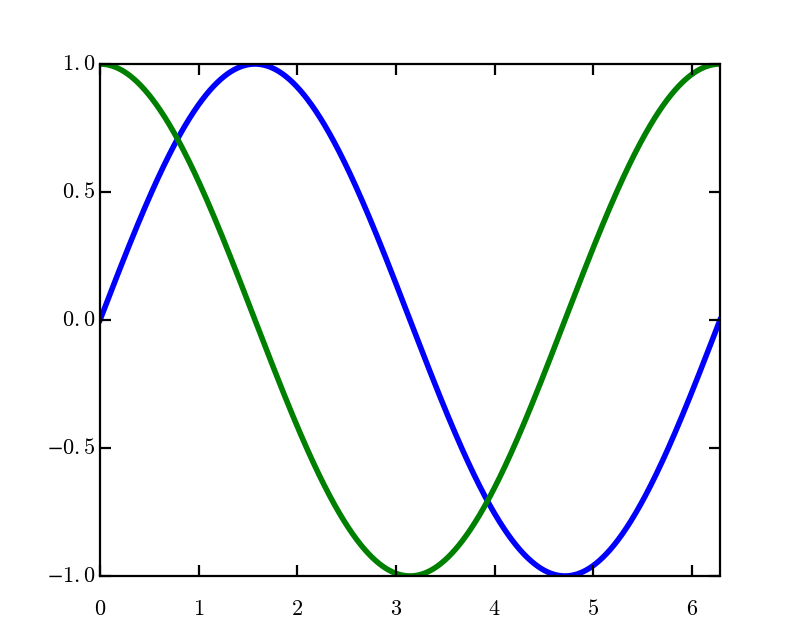

In [9]:
leheny = 'http://tiny.cc/leheny-style/raw'

with ms.context(leheny):
    fig, ax = plt.subplots()
    ln_sin, = ax.plot(th, np.sin(th))
    ln_cos, = ax.plot(th, np.cos(th))
    ax.set_xlim(0, 2*np.pi)

## Automatic updating without pyplot

<IPython.core.display.Javascript object>


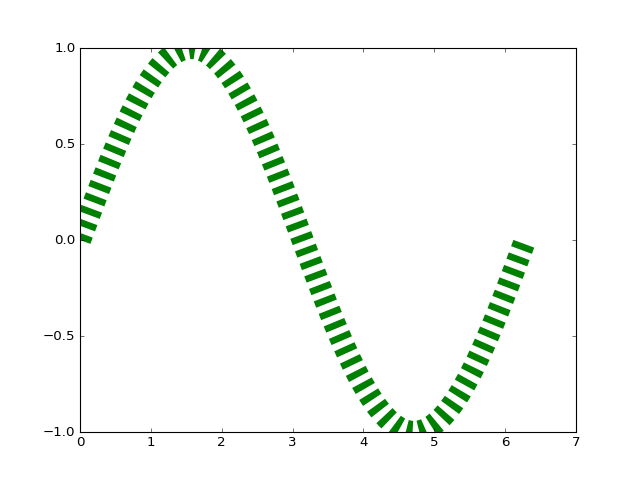

In [10]:
fig, ax = plt.subplots()
ln, = ax.plot(th, np.sin(th), ls='--')

In [11]:
ln.set_color('green')
ln.set_linewidth(20)

## String labels to bar plots

<IPython.core.display.Javascript object>


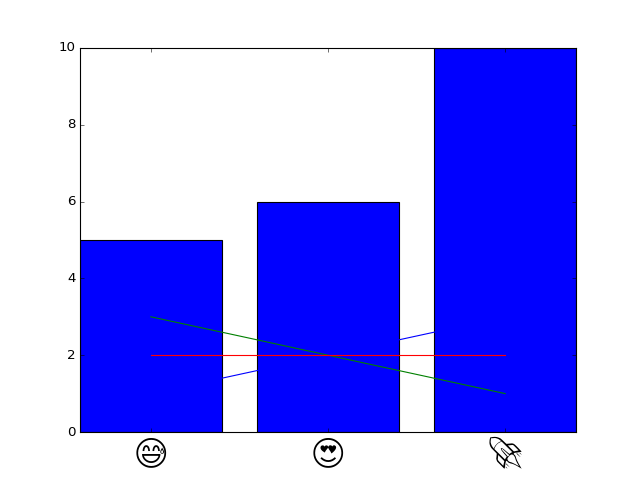

[(None, None), (None, None), (None, None)]

In [12]:
fig, ax = plt.subplots()
ax.bar(range(3), [5, 6, 10], tick_label=list('😅😍🚀'), align='center')
[(t.set_fontname('symbola'), t.set_fontsize(32)) for t in ax.xaxis.get_ticklabels()]

## Cycler

In [13]:
import cycler as cr

In [14]:
with plt.rc_context(rc={'axes.prop_cycle': "cycler('color', 'k') * cycler('ls', ['-', '--', ':'])"}):
    plt.plot([1, 2, 3])
    plt.plot([3, 2, 1])
    plt.plot([2, 2, 2])

In [15]:
from cycler import cycler
cmap = cycler('cmap', ['viridis', 'magma','plasma', 'inferno'])
x_mode = cycler('x', [1, 2])
y_mode = cycler('y', x_mode)

def demo(ax, x, y, cmap):
    X, Y = np.ogrid[0:2*np.pi:200j, 0:2*np.pi:200j]
    data = np.sin(X*x) * np.cos(Y*y)
    ax.imshow(data, interpolation='none', cmap=cmap)
    ax.set_title(cmap)

<IPython.core.display.Javascript object>


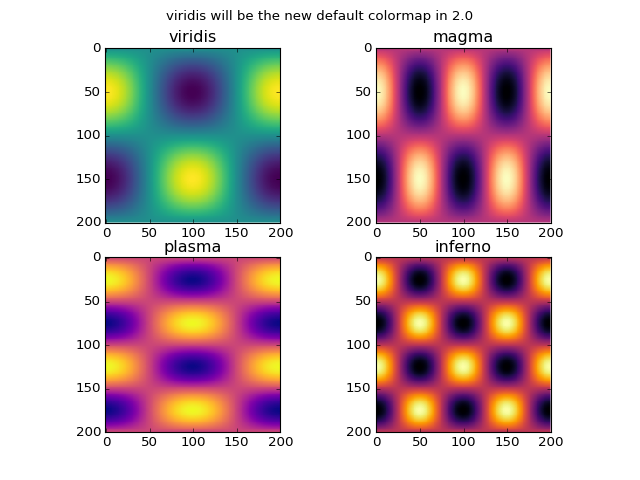

In [16]:
cy = (x_mode * y_mode) + cmap 


fig, axes = plt.subplots(2, 2)
for ax, sty in zip(axes.ravel(), cy):
    demo(ax, **sty)
fig.suptitle('viridis will be the new default colormap in 2.0')

## Labeled data support

In [17]:
autos = pd.read_csv('auto-mpg.csv')
autos

,mpg,cyl,displ,hp,weight,accel,yr,origin,name
0,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15,8,350,165,3693,11.5,70,1,buick skylark 320
2,18,8,318,150,3436,11.0,70,1,plymouth satellite
3,16,8,304,150,3433,12.0,70,1,amc rebel sst
4,17,8,302,140,3449,10.5,70,1,ford torino
5,15,8,429,198,4341,10.0,70,1,ford galaxie 500
6,14,8,454,220,4354,9.0,70,1,chevrolet impala
7,14,8,440,215,4312,8.5,70,1,plymouth fury iii
8,14,8,455,225,4425,10.0,70,1,pontiac catalina
9,15,8,390,190,3850,8.5,70,1,amc ambassador dpl


<IPython.core.display.Javascript object>


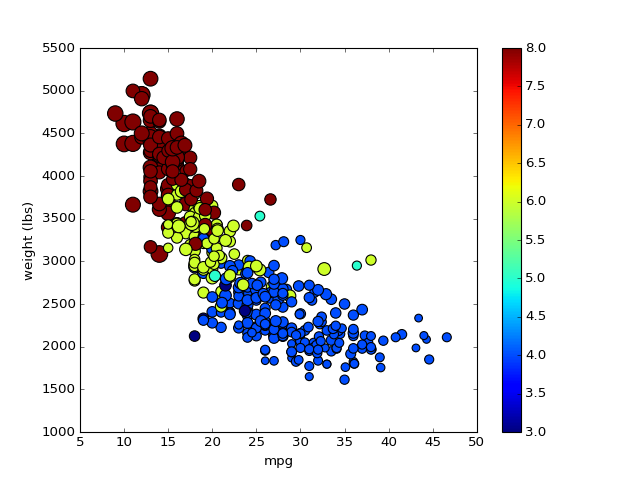

In [18]:
fig, ax = plt.subplots()
sc = ax.scatter('mpg', 'weight', 'hp', 'cyl', data=autos)
plt.colorbar(sc)
ax.set_ylabel('weight (lbs)')
ax.set_xlabel('mpg')

## Easy faceting

<IPython.core.display.Javascript object>


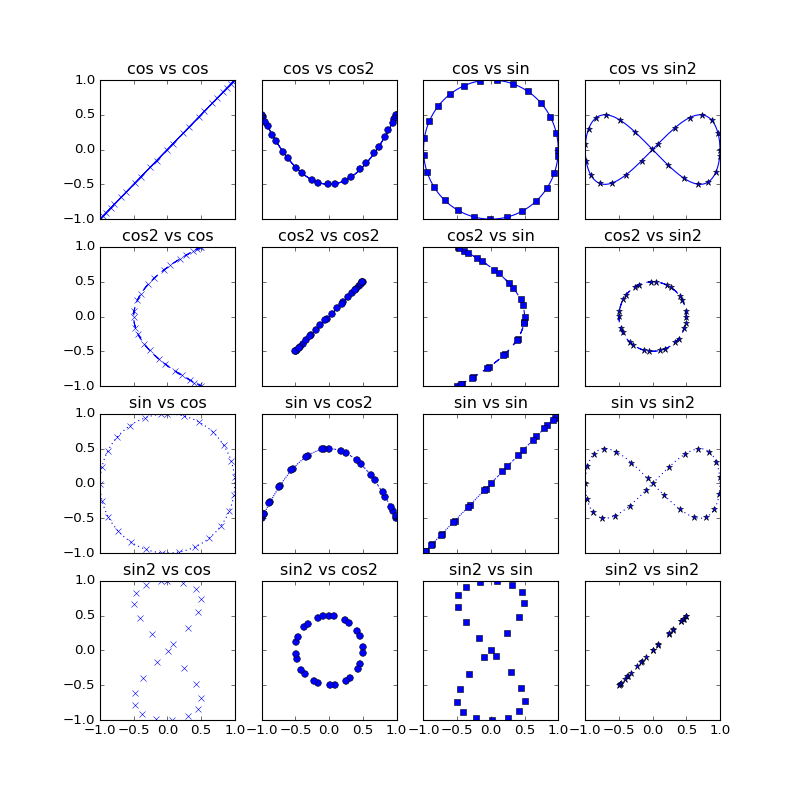

In [19]:

from cycler import cycler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def simple_plot(ax, x, y, **kwargs):
    return ax.plot(x, y, **kwargs)

th = np.linspace(0, 2*np.pi, 128)
df = pd.DataFrame({'sin': np.sin(th), 'cos': np.cos(th),
                   'sin2': .5 * np.sin(2 * th), 'cos2': .5 * np.cos(2 * th)})

def easy_facet(df, cycle1, cycle2):
    cycleX = (cycler('x', df.keys()) + cycle1)
    cycleY = (cycler('y', df.keys()) + cycle2) 
    kw_cycle = cycleX * cycleY

    fig, axes = plt.subplots(len(df.keys()), len(df.keys()), sharex=True, sharey=True,
                             figsize=(10, 10))
    lines = []
    axes[0, 0].set_xlim([-1, 1])
    axes[0, 0].set_ylim([-1, 1])
    for ax, kwargs in zip(axes.ravel(), kw_cycle):
        
        ln, = simple_plot(ax, markevery=5, data=df, **kwargs)
        ax.set_title('{x} vs {y}'.format(**kwargs))
        lines.append(ln)
        
    return lines


arts = easy_facet(df, cycler('linestyle', ['-', '--', ':', '']), cycler('marker', 'xos*'))

## Other new features

 - auto-wrapping of long text
 
 <img src="whats_new-2.png"/>
 
 - contour corner masking
 
 <img src="contour_corner_mask2.png"/>
 
 - bar plots with labels
 - smooth colorbars
 - legend support for more collections
 - per-artist usetex control
 - unified line style across Line, Patch, and Collection
 - add page notes in multi-page pdfs
 - support both wxpython classic and wxpython phoenix (python 3 support)
 - Added 'logit' axis scale
 - Major improvements to table


# The future

## Version 2.0

### Style changes only

## Version 2.1

### Better interoperability

 - nbagg + widget integration (jupyter notebook, Steven Silvester)
 - better containers classes 
 - serialization & traitlets (Brian Granger / Ryan Morshead)
 
## Beyond
 
<img src="lego2.jpg"/>

### Place in community

 - we really are low on resources, but that's improving
 - always looking for new contributors 
 - usage now well outside domain knowledge of core-devs
  - looking for domain experts to develop specialized plotting tools
  - happy to host projects built on top of mpl under matplotlib.org organization
 - we are a substrate for domain-specific plotting (seaborn, pandas, glueviz, holoviews etc)

## Thank you

  - John Hunter

In [ ]:
import textwrap
commits = pd.read_csv('commits_time_author.csv', sep='&')
commiters = Counter(commits['name'])
print('\n'.join(textwrap.wrap(', '.join(sorted([n.split('<')[0].rstrip() for n in commiters.keys()])))))